# Demo LoFTR-DS on a single pair of images

This notebook shows how to use the loftr matcher with default config(dual-softmax) and the pretrained weights.

In [17]:
%reload_ext autoreload
%autoreload 2
import os
os.chdir("D:\loftr")

In [41]:
from copy import deepcopy

import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from PIL import Image
from src.utils.plotting import make_matching_figure
from scripts.test_visnir import load_mt_model, load_loftr, predict_loftr, extract_descriptors_around_keypoints, best_matches

## Indoor Example

In [19]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
_default_cfg = deepcopy(default_cfg)
_default_cfg['coarse']['temp_bug_fix'] = True  # set to False when using the old ckpt
matcher = LoFTR(config=_default_cfg)
matcher.load_state_dict(torch.load("weights/indoor_ds_new.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [20]:
# Load example images
img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

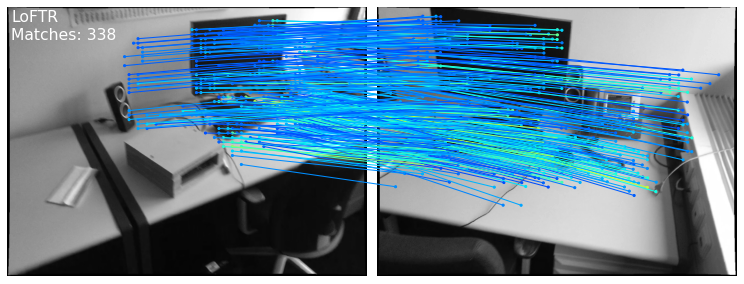

In [21]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)

## Outdoor Example

In [22]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

In [23]:
default_cfg['coarse']

{'d_model': 256,
 'd_ffn': 256,
 'nhead': 8,
 'layer_names': ['self',
  'cross',
  'self',
  'cross',
  'self',
  'cross',
  'self',
  'cross'],
 'attention': 'linear',
 'temp_bug_fix': False}

In [24]:
# Load example images
img0_pth = "assets/phototourism_sample_images/united_states_capitol_26757027_6717084061.jpg"
img1_pth = "assets/phototourism_sample_images/united_states_capitol_98169888_3347710852.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8))  # input size shuold be divisible by 8
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()
dist = np.linalg.norm(mkpts0 - mkpts1, axis=1)
inliners = dist[dist < 5]
outliers = dist[dist >= 5]
mean_error = np.mean([d for d in outliers])
print(f'Inliners/Outliers: {len(inliners)}/{len(outliers)}')
print(f'Mean error: {mean_error}')

Inliners/Outliers: 0/843
Mean error: 103.65629577636719


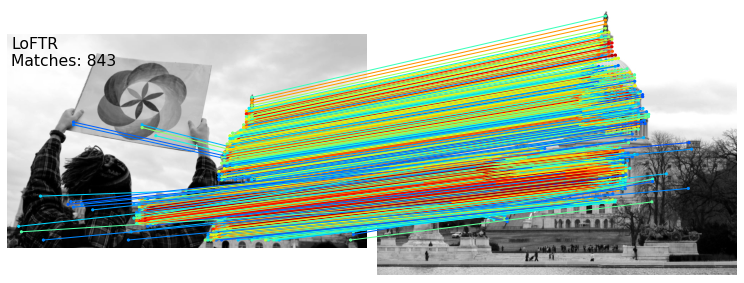

In [25]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)

In [52]:
# Load example images
img0_pth = 'D:/multisensor/datasets/Vis-Nir/data/water/0003_rgb.tiff'
img1_pth = 'D:/multisensor/datasets/Vis-Nir/data/water/0003_nir.tiff'
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8))  # input size shuold be divisible by 8
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mconf = batch['mconf'].cpu().numpy()
    topk = mconf.argsort()[-50:][::-1]
    mconf = mconf[topk]
    mkpts0 = batch['mkpts0_f'].cpu().numpy()[topk]
    mkpts1 = batch['mkpts1_f'].cpu().numpy()[topk]
    
dist = np.linalg.norm(mkpts0 - mkpts1, axis=1)
inliners = dist[dist < 5]
outliers = dist[dist >= 5]
mean_error = 0.
if outliers:
    mean_error = np.mean([d for d in outliers])
print(f'Inliners/Outliers: {len(inliners)}/{len(outliers)}')
print(f'Mean error: {mean_error}')

Inliners/Outliers: 50/0
Mean error: 0.0


C:\Users\keller\AppData\Local\Temp\ipykernel_3872\859383170.py:26: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if outliers:


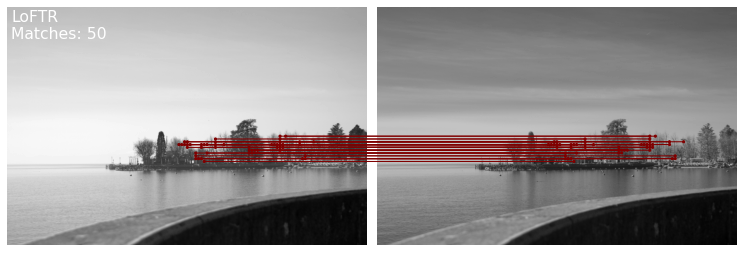

In [53]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)

In [54]:
from pathlib import Path
def load_test_files(dir):
    rgb = []
    nir = []
    for path in Path(dir).rglob('*_rgb.tiff'):
        full_path = str(path.resolve())
        if '\\country\\' not in full_path:
            rgb.append(full_path)
            nir.append(full_path.replace('_rgb', '_nir'))
    return rgb, nir
rgb, nir = load_test_files('D:/multisensor/datasets/Vis-Nir/data')
print('Loaded', len(rgb) + len(nir), 'files')

Loaded 850 files


In [55]:
results = {}
loftr = load_loftr()
mt_model = load_mt_model()
for img0_pth, img1_pth in zip(rgb, nir):
    # Load in two images
    # transform = transforms.Compose([
    #     transforms.Resize((512, 512)),
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # ])

    img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
    img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
    img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8))  # input size shuold be divisible by 8
    img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
    kps1, kps2 = predict_loftr(loftr, img0, img1, topk=200)
    
    dist = np.linalg.norm(kps1 - kps2, axis=1)
    inliners = dist[dist < 5]
    outliers = dist[dist >= 5]
    results[(img0_pth, img1_pth)] = {
        'inliners': inliners,
        'outliers': outliers
    }

In [56]:
inliners_mean = np.mean([len(res['inliners']) for _, res in results.items()])
outliers_mean = np.mean([len(res['outliers']) for _, res in results.items()])
mean_error = np.mean([d for _, res in results.items() for d in res['outliers']])
print(f'Inliners/Outliers: {inliners_mean}/{outliers_mean}')
print(f'Mean error: {mean_error}')

Inliners/Outliers: 192.69411764705882/7.305882352941176
Mean error: 11.287557601928711


In [57]:
results = {}
loftr = load_loftr()
mt_model = load_mt_model()
for img0_pth, img1_pth in zip(rgb, nir):
    # Load in two images
    # transform = transforms.Compose([
    #     transforms.Resize((512, 512)),
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # ])

    img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
    img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
    img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8))  # input size shuold be divisible by 8
    img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
    kps1, kps2 = predict_loftr(loftr, img0, img1, topk=300)
    
    descriptors = extract_descriptors_around_keypoints(mt_model, Image.fromarray(img0_raw), Image.fromarray(img1_raw), kps1, kps2)
    matches, _ = best_matches(descriptors, topk=200, T=0)
    _, idxs = matches[:, 0].sort(dim=0)
    matches = matches[idxs, :]
    kps1, kps2 = kps1[matches[:, 0], :], kps2[matches[:, 1], :]
    
    
    dist = np.linalg.norm(kps1 - kps2, axis=1)
    inliners = dist[dist < 5]
    outliers = dist[dist >= 5]
    results[(img0_pth, img1_pth)] = {
        'inliners': inliners,
        'outliers': outliers
    }

In [58]:
inliners_mean = np.mean([len(res['inliners']) for _, res in results.items()])
outliers_mean = np.mean([len(res['outliers']) for _, res in results.items()])
mean_error = np.mean([d for _, res in results.items() for d in res['outliers']])
print(f'Multiscale Inliners/Outliers: {inliners_mean}/{outliers_mean}')
print(f'Multiscale mean error: {mean_error}')

Multiscale Inliners/Outliers: 193.18588235294118/6.727058823529412
Multiscale mean error: 10.94943904876709
